#              FACE MASK DETECTION USING TRANSFER LEARNING
***
**MINI PROJECT BATCH-K2** --------------------------------------------------------------------------------------------------------------**GUIDED BY:- Prof M.Akka Lakshmi**
***

### BATCHMATES :-
- Sourav Mohanty  (221710311052)
- Aditya Sai Mullapudi (221710311001)
- Zafeer Khan Pattan (221710311042)
- Suhasini Reddy Kancharla (221710311025)

## IMPORTING ESSENTIAL MODULES

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil
import itertools

%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Activation, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

## FETCHING OUR DATASET
>Thanks to [Prajna Bhandary](https://github.com/prajnasb/observations) for compiling the dataset that I have used for training.

- After getting the dataset I have classified the images and stored them into two folders with_mask and without_mask
- I have created two folders one for train and the other for test. The reason for not creating the validation set is because i am using **ImageDataGenerator** to create batches and by using the **'subset'** option we can split the train data into training as well as validation set.
- I have assigned data paths to specific variables


In [9]:
train_path = 'C:/Users/soura/Desktop/Project/mini/data/train'
test_path = 'C:/Users/soura/Desktop/Project/mini/data/test'
MASKPATH = 'C:/Users/soura/Desktop/Project/mini/data/train/with_mask'
NOMASKPATH = 'C:/Users/soura/Desktop/Project/mini/data/train/without_mask'

## VISUALIZING OUR DATA
This VIEW function helps us to display our dataset images in the form of rows and columns

In [10]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),12):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=4, figsize=(30,20))
    for row in range(3):
        for col in range(4):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

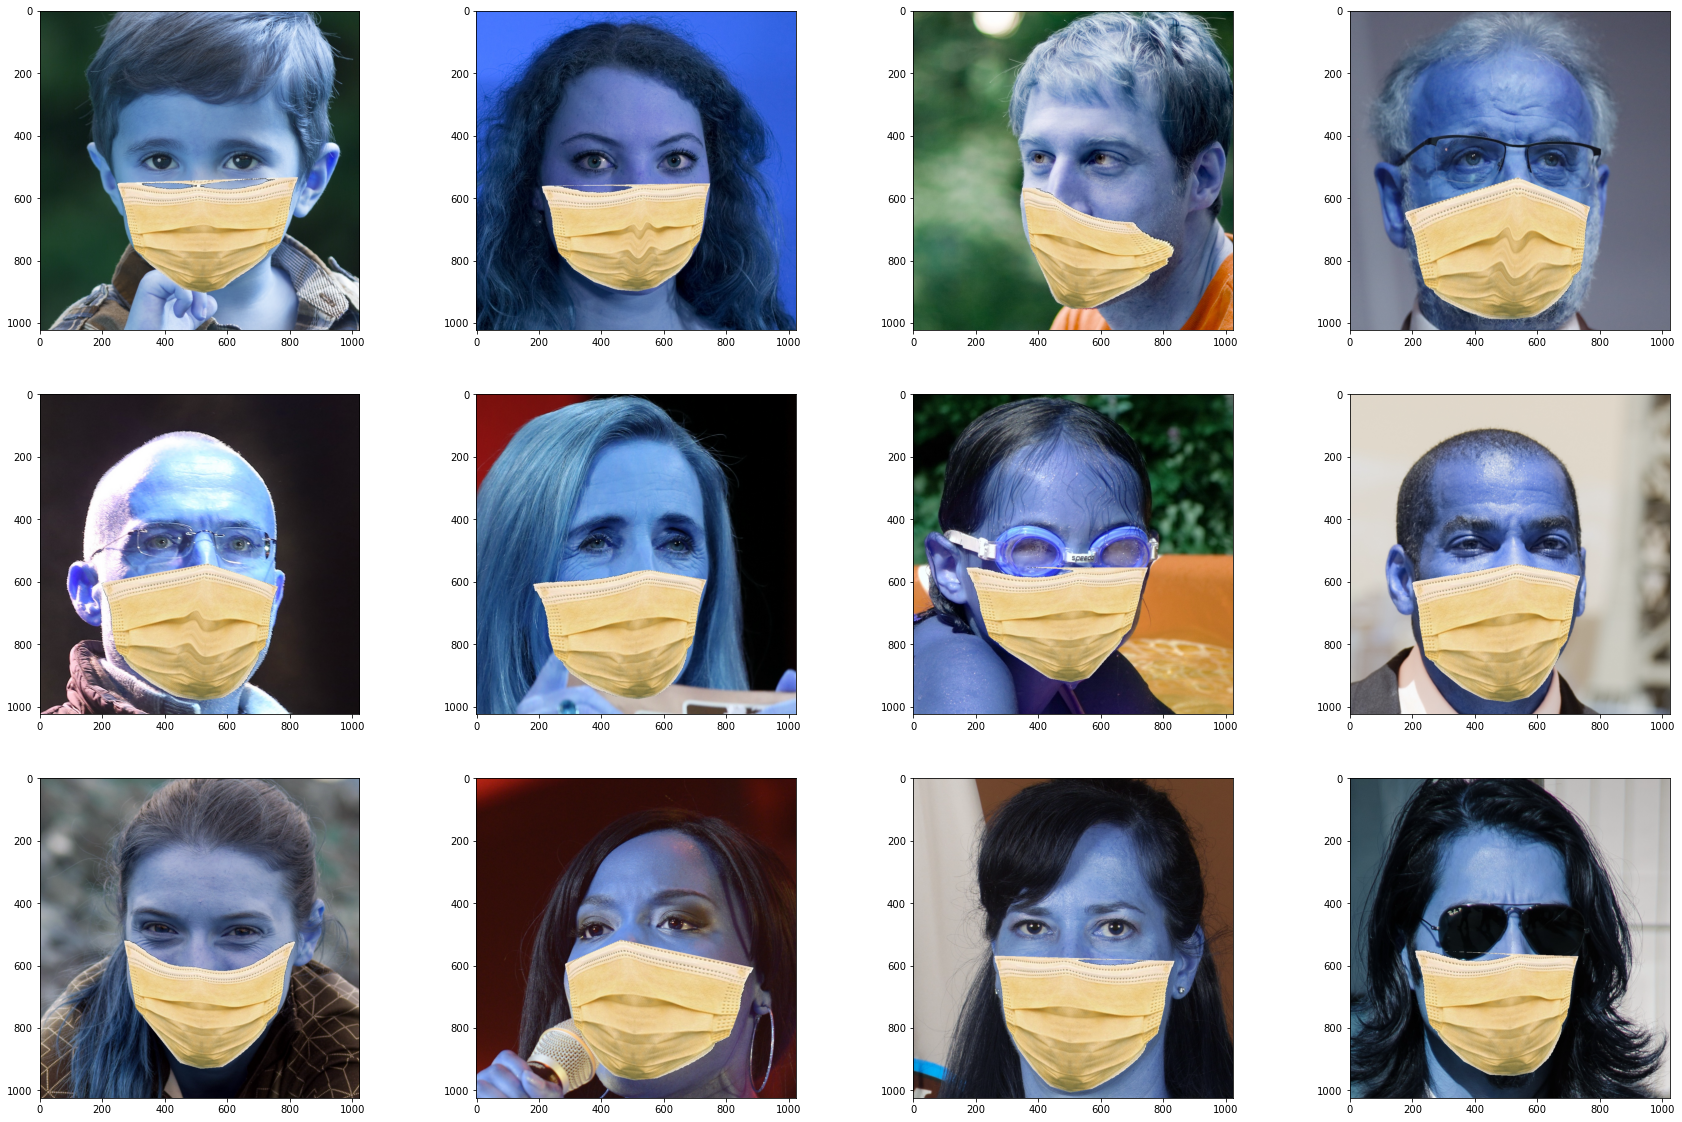

In [11]:
view(MASKPATH)

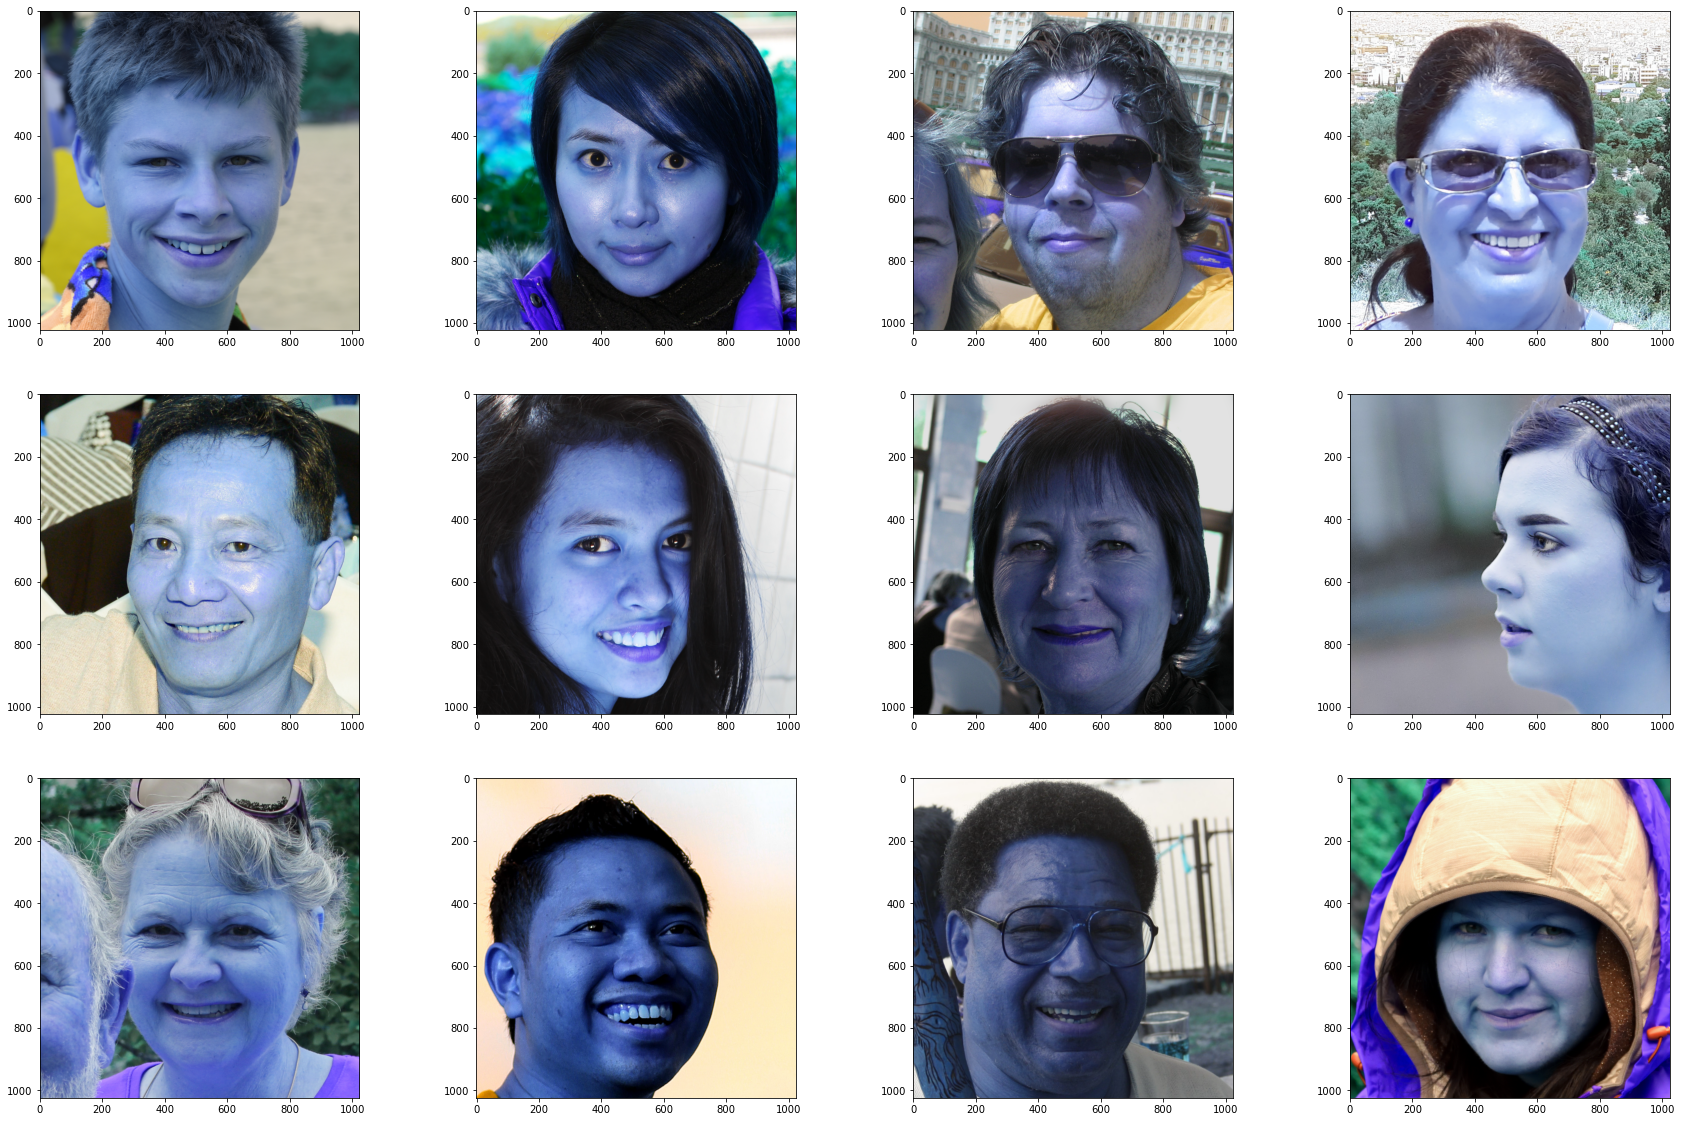

In [12]:
view(NOMASKPATH)

##  ANALYSING OUR DATA

In [13]:
fig = go.Figure(
    data=[go.Pie(labels=['WITHMASK','WITHOUTMASK'], 
        values=[len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))])
    ])
fig.show()

***So clearly our Data is not highly imbalanced.Though we have less in number but we have good data to work around with.***

## GENETATING DATA INPUT PIPELINES
- Now, we use Keras' ImageDataGenerator class to create batches of data from the train and test directories.
- ImageDataGenerator.flow_from_directory() creates a DirectoryIterator, which generates batches of normalized tensor image data from the respective data directories.

In [14]:
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=['with_mask','without_mask'],batch_size=32, subset='training')

valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.3).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=['with_mask','without_mask'],batch_size=32, subset = 'validation')

test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), classes=['with_mask','without_mask'],batch_size=32, shuffle=False)

Found 1950 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 1292 images belonging to 2 classes.


We then use this plotting function obtained from [TensorFlow's documentation](https://www.tensorflow.org/tutorials/images/classification#visualize_training_images) to plot the processed images within our Jupyter notebook.

In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

- We now call next(train_batches) to generate a batch of images and labels from the training set. Note that the size of this batch is determined by the batch_size we set when we created train_batches.
- Note that without_mask are represented with the one-hot encoding of [0,1], and with_mask are represented by [1,0].

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

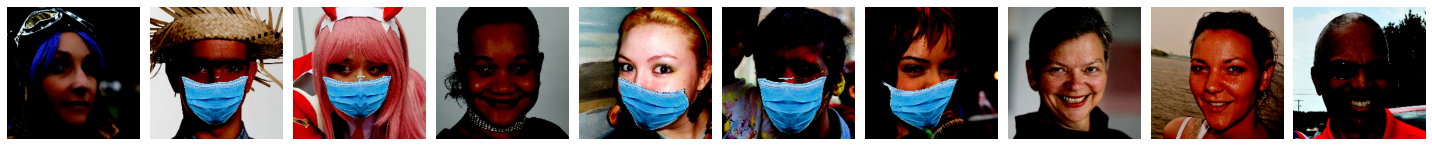

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [16]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

## BUILDING OUR MODEL
*Fine-Tuning MobileNet On our face-mask Data Set With TensorFlow's Keras API*

Next, we’re going to grab the output from the first to last second layer of the model and store it in this variable x.
We’ll be using this to build a new model. This new model will consist of the original MobileNet up to the last second layer.

In [17]:
mob = MobileNetV2()
x = mob.layers[-2].output

14540800/14536120 [==============================] - 3s 0us/step


Now, we create an output layer that we’re calling output, which will just be a Dense layer with 2 output nodes for the two corresponding classes, and we’ll use the softmax activation function.

In [18]:
output = Dense(units=2, activation='softmax')(x)

Now, we construct the new fine-tuned model, which we’re calling model.

The Model constructor used to specify a model that is being created with the Keras Functional API, not the Sequential API 

In [19]:
model = Model(inputs=mob.input, outputs=output)

Now, we need to choose how many layers we actually want to be trained when we train on our new data set.

- I did a little experimenting and research and found that training the last 23 layers will give us a pretty decently performing model.
- So the twenty-third-to-last layer and all layers after it will be trained when we fit the model on the new data set. All layers above will not be trained, so their original ImageNet weights will stay in place.

In [20]:
for layer in model.layers[:-23]:
    layer.trainable = False
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [21]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Compile The Model

In [22]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

- Creating a checkpoint so with specific parameters so that with every epoch my model stores only those weights that have low validation loss

In [23]:
checkpoint = ModelCheckpoint(
    'mask_recog.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

## Train The Model

In [24]:
hist=model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=15,
            callbacks = [checkpoint]
)

Epoch 1/15
61/61 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9836
Epoch 00001: val_loss improved from inf to 0.00056, saving model to mask_recog.h5
61/61 [==============================] - 135s 2s/step - loss: 0.0516 - accuracy: 0.9836 - val_loss: 5.5503e-04 - val_accuracy: 1.0000
Epoch 2/15
61/61 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 00002: val_loss improved from 0.00056 to 0.00016, saving model to mask_recog.h5
61/61 [==============================] - 120s 2s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.5997e-04 - val_accuracy: 1.0000
Epoch 3/15
61/61 [==============================] - ETA: 0s - loss: 4.3378e-04 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.00016 to 0.00010, saving model to mask_recog.h5
61/61 [==============================] - 120s 2s/step - loss: 4.3378e-04 - accuracy: 1.0000 - val_loss: 1.0235e-04 - val_accuracy: 1.0000
Epoch 4/15
61/61 [==============================] - ET

In [25]:
model.evaluate(test_batches)

41/41 [==============================] - 27s 665ms/step - loss: 0.0689 - accuracy: 0.9737


[0.06892931461334229, 0.9736841917037964]

## Plotting the metrics 

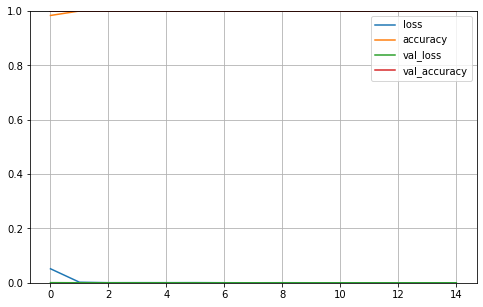

In [26]:
pd.DataFrame(hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()


## Use The Model For Inference
On to the predictions!

In [27]:
test_labels = test_batches.classes

In [28]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
predictions

array([[9.8000127e-01, 1.9998785e-02],
       [9.5167392e-01, 4.8326068e-02],
       [9.9223083e-01, 7.7691847e-03],
       ...,
       [6.9554471e-07, 9.9999928e-01],
       [6.7394069e-07, 9.9999928e-01],
       [2.2980106e-05, 9.9997699e-01]], dtype=float32)

We then create a confusion_matrix object using scikit-learn’s confusion_matrix that we imported.

In [29]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

- We now bring in the same plot_confusion_matrix function from scikit-learn .This function plots the confusion matrix in a graphical manner

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
test_batches.class_indices

{'with_mask': 0, 'without_mask': 1}

Confusion matrix, without normalization
[[614  34]
 [  0 644]]


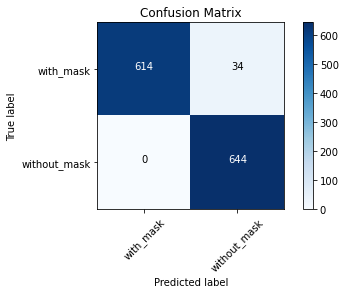

In [32]:
cm_plot_labels = ['with_mask','without_mask']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       648
           1       0.95      1.00      0.97       644

    accuracy                           0.97      1292
   macro avg       0.97      0.97      0.97      1292
weighted avg       0.98      0.97      0.97      1292



---
***
***
# CHANGES MADE AFTER REVIEW 2 :-
> - We drew all the essential UML diagrams .
> - We implented the confusion Matrix 
> - we plotted the classification report showing precision, recall, f1-score, support as per asked by our coordinator
> - We have also created a python app using Tkinter and a Web App Using Streamlit To make our Project User-Friendly.

***
***
### Individual Changes
> - Changed our model from sequential to Functional 
> - Instead of freezing the entire mobilenet model we have kept the last 23 layers weights to be retrained.
> - Added only one extra dense layer representing our output layer
>> **MODEL BEFORE CHANGES**
![](images/previous_model.jpg)

> - Instead of Manually Resclaing images we have used Preprocess_input() function provided by keras 
>> **DATA INPUT PIPELINES BEFORE CHANGES**
![](images/Capture.jpg)